In [28]:
from helper_functions import *
import itertools
import os
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import sqlite3
import re
from datetime import datetime
from tqdm import tqdm
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import swifter
import string
from pprint import pprint
from time import time

# import classifiers
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import column_or_1d
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, svm
from sklearn import decomposition, ensemble
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, classification_report, roc_curve, auc, accuracy_score  

In [3]:
df = pd.read_pickle('../data/final_df.pkl')

In [4]:
df.head(3)

,date,reviewID,reviewerID,reviewContent,review_rating,review_usefulCount,review_coolCount,review_funnyCount,flagged,restaurantID,...,max_similarity,total_review,fake_review,fake_review_ratio,avg_length,max_review,extreme_ratio,res_total_review,res_fake_review,res_fake_review_ratio
0,2012-09-25,xvdJntJlo01tHu83-vXiRw,bNYesZ944s6IJVowOnB0iA,Good choice by our Chicago friends for our fin...,4,0,0,0,0,KU_Ze0TpR2HgKG2OpTh2NA,...,0.473407,44,6,0.136364,1235.409091,5,0.204545,91,73,0.802198
1,2012-06-23,Z4oAUd6mIOhxxDsle3trPA,BSh3h1J4mdSmEsb8FFdf0Q,"I'm not a Takashi fan, so I was a bit hesitant...",4,0,0,0,1,KU_Ze0TpR2HgKG2OpTh2NA,...,0.268346,94,60,0.638298,830.148936,13,0.074468,91,73,0.802198
2,2012-10-10,71c7BDude0l5tNjtxRZzMg,XVvbDeYn5Dk-MteNHwjC7Q,I should have read the the 3 stars and below r...,2,0,0,0,0,KU_Ze0TpR2HgKG2OpTh2NA,...,0.210318,13,2,0.153846,392.769231,3,0.230769,91,73,0.802198


In [5]:
# remove columns not used in models
df.columns

Index(['date', 'reviewID', 'reviewerID', 'reviewContent', 'review_rating',
       'review_usefulCount', 'review_coolCount', 'review_funnyCount',
       'flagged', 'restaurantID', 'reviewer_name', 'location', 'yelpJoinDate',
       'friendCount', 'reviewCount', 'firstCount', 'usefulCount', 'coolCount',
       'funnyCount', 'complimentCount', 'tipCount', 'fanCount',
       'restaurant_name', 'rating', 'processed_text', 'polarity', 'review_len',
       'word_count', 'abs_polarity', 'avg_polarity', 'restaurant_avg_rating',
       'rating_dev', 'time_ratio', 'ave_similarity', 'max_similarity',
       'total_review', 'fake_review', 'fake_review_ratio', 'avg_length',
       'max_review', 'extreme_ratio', 'res_total_review', 'res_fake_review',
       'res_fake_review_ratio'],
      dtype='object')

In [6]:
remove_cols = ['date', 'reviewID', 'reviewerID', 'reviewContent', 'restaurantID',
              'restaurant_name', 'processed_text', 'reviewer_name', 'location', 'yelpJoinDate']
df_model = df.drop(columns= remove_cols)

In [7]:
df_model.head(3)

,review_rating,review_usefulCount,review_coolCount,review_funnyCount,flagged,friendCount,reviewCount,firstCount,usefulCount,coolCount,...,max_similarity,total_review,fake_review,fake_review_ratio,avg_length,max_review,extreme_ratio,res_total_review,res_fake_review,res_fake_review_ratio
0,4,0,0,0,0,11,48,5,41,5,...,0.473407,44,6,0.136364,1235.409091,5,0.204545,91,73,0.802198
1,4,0,0,0,1,34,116,2,93,16,...,0.268346,94,60,0.638298,830.148936,13,0.074468,91,73,0.802198
2,2,0,0,0,0,2,14,1,5,1,...,0.210318,13,2,0.153846,392.769231,3,0.230769,91,73,0.802198


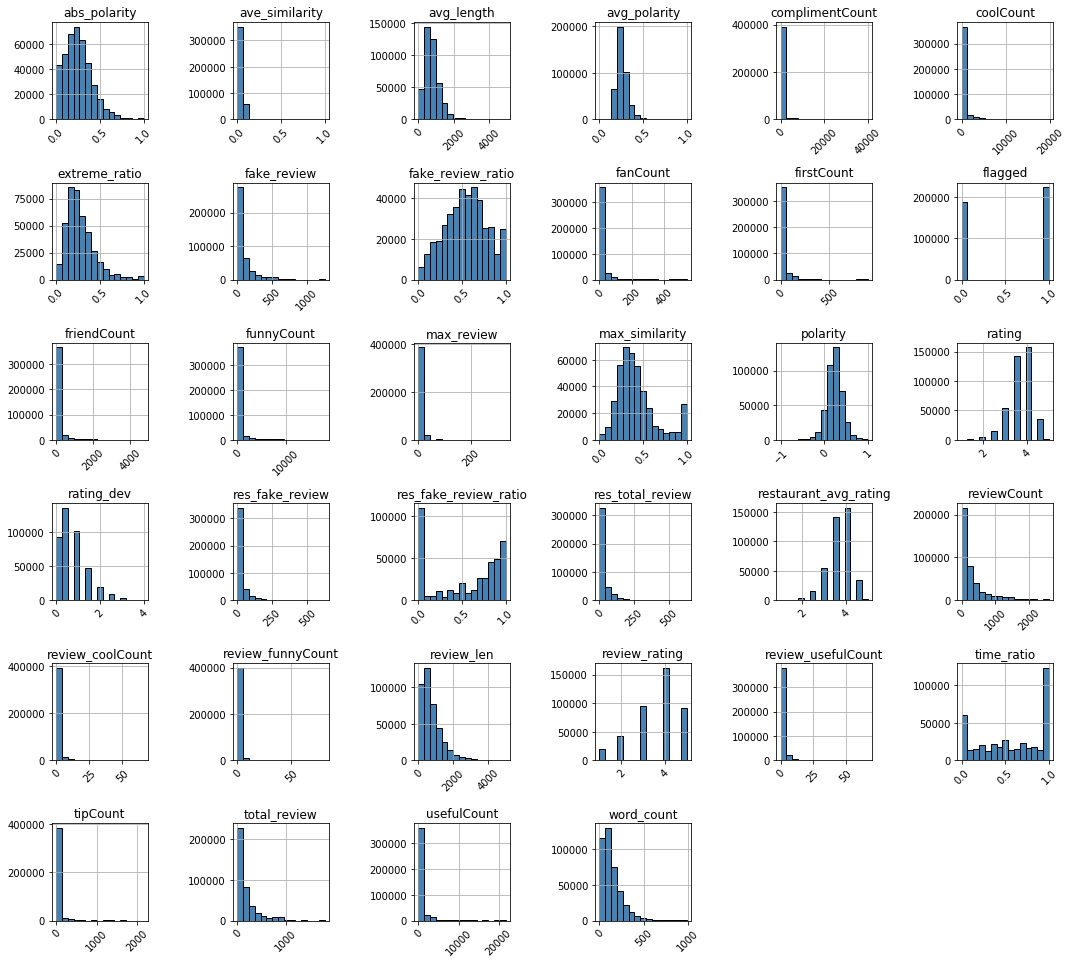

In [8]:
fig = df_model.hist(bins=15,
                 color='steelblue',
                 edgecolor='black', linewidth=1.0,
                 xlabelsize=10, ylabelsize=10,
                 xrot=45, yrot=0,
                 figsize=(10,9),
                 grid=True)

plt.tight_layout(rect=(0, 0, 1.5, 1.5))   

In [9]:
corr = df_model.corr()
corr

,review_rating,review_usefulCount,review_coolCount,review_funnyCount,flagged,friendCount,reviewCount,firstCount,usefulCount,coolCount,...,max_similarity,total_review,fake_review,fake_review_ratio,avg_length,max_review,extreme_ratio,res_total_review,res_fake_review,res_fake_review_ratio
review_rating,1.000000,-0.006008,0.065903,-0.039654,0.075109,0.006567,-0.027228,-0.004650,-0.015052,-0.012870,...,-0.029781,-0.033882,-0.025911,0.030825,-0.028936,-0.024165,0.138594,0.070760,0.072432,0.097466
review_usefulCount,-0.006008,1.000000,0.871294,0.756686,-0.090869,0.481304,0.347613,0.242773,0.556863,0.556250,...,0.161730,0.312120,0.224012,-0.132035,0.352938,-0.017759,-0.111494,-0.066599,-0.060642,-0.034070
review_coolCount,0.065903,0.871294,1.000000,0.811441,-0.049552,0.501256,0.368469,0.248213,0.590748,0.596394,...,0.164283,0.333696,0.248944,-0.103330,0.346212,-0.012443,-0.120364,-0.055438,-0.048361,0.005405
review_funnyCount,-0.039654,0.756686,0.811441,1.000000,-0.053929,0.387281,0.279032,0.165999,0.477038,0.483121,...,0.120863,0.257037,0.191565,-0.092474,0.309898,-0.020098,-0.092167,-0.041904,-0.036738,-0.002721
flagged,0.075109,-0.090869,-0.049552,-0.053929,1.000000,-0.046398,-0.050790,-0.094087,-0.054362,-0.047752,...,-0.086337,-0.036724,0.054514,0.475606,-0.085241,0.008115,0.063842,0.317382,0.320149,0.774659
friendCount,0.006567,0.481304,0.501256,0.387281,-0.046398,1.000000,0.608461,0.380383,0.813338,0.793595,...,0.264949,0.543874,0.445705,-0.097556,0.315507,0.066143,-0.163496,-0.079062,-0.070122,-0.008717
reviewCount,-0.027228,0.347613,0.368469,0.279032,-0.050790,0.608461,1.000000,0.672553,0.732790,0.693964,...,0.559209,0.964342,0.887835,-0.106790,0.253394,0.360755,-0.282328,-0.152460,-0.136005,-0.018549
firstCount,-0.004650,0.242773,0.248213,0.165999,-0.094087,0.380383,0.672553,1.000000,0.514317,0.485670,...,0.341519,0.543876,0.409678,-0.197824,0.101584,0.159339,-0.105426,-0.097749,-0.090050,-0.090483
usefulCount,-0.015052,0.556863,0.590748,0.477038,-0.054362,0.813338,0.732790,0.514317,1.000000,0.995149,...,0.311580,0.671192,0.534220,-0.114300,0.411494,0.058288,-0.187544,-0.087727,-0.078110,-0.015947
coolCount,-0.012870,0.556250,0.596394,0.483121,-0.047752,0.793595,0.693964,0.485670,0.995149,1.000000,...,0.280806,0.635904,0.504546,-0.100403,0.405150,0.041039,-0.175216,-0.081581,-0.072337,-0.010028


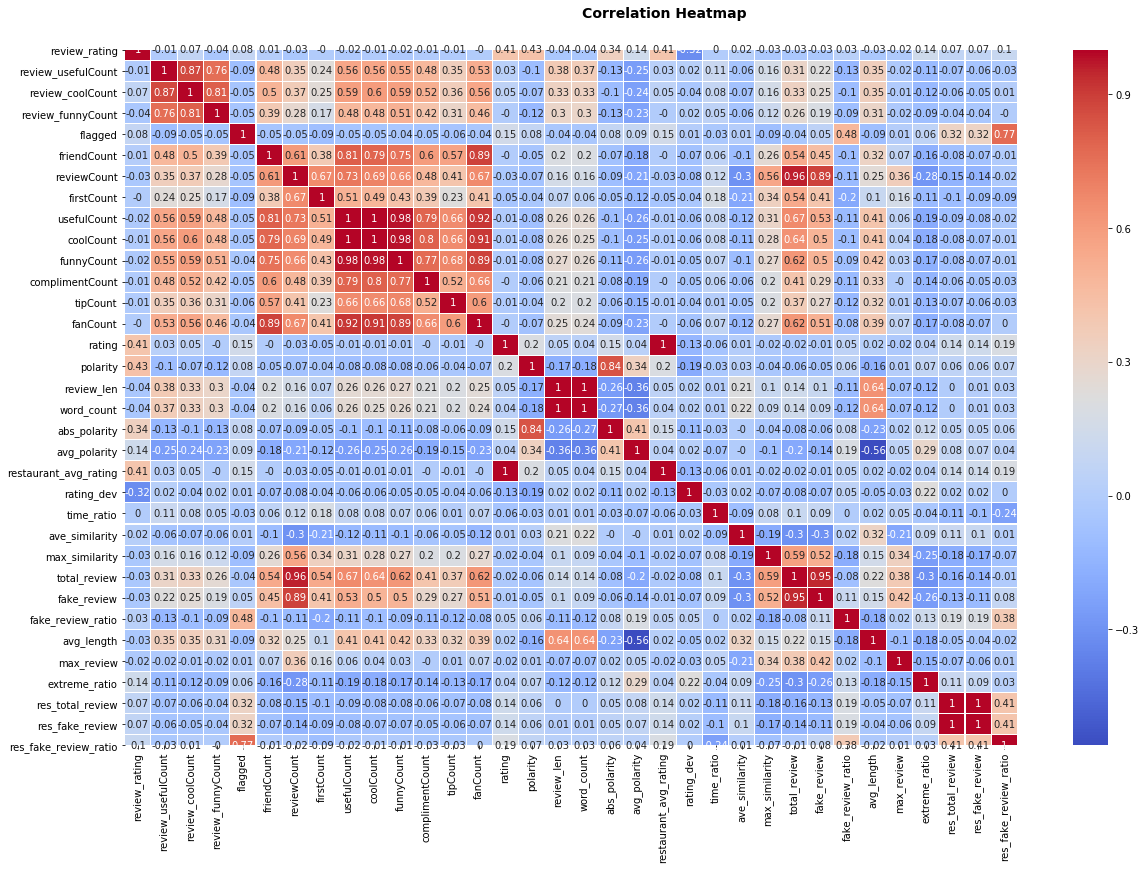

In [10]:
fig, ax = plt.subplots(1,1, figsize=(20,12))

hm = sns.heatmap(round(corr,2), 
                 ax=ax,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 cmap="coolwarm", # Color Map.
                 #square=True,    # If True, set the Axes aspect to “equal” so each cell will be square-shaped.
                 annot=True, 
                 #annot_kws={"size": 14},
                 linewidths=.05)

fig.subplots_adjust(top=0.93)

t = fig.suptitle('Correlation Heatmap', fontsize=14, fontweight='bold')

In [11]:
def filter_df_corr(inp_data, corr_val):
    '''
    Returns an array or dataframe (based on type(inp_data) adjusted to drop \
        columns with high correlation to one another. Takes second arg corr_val
        that defines the cutoff

    ----------
    inp_data : np.array, pd.DataFrame
        Values to consider
    corr_val : float
        Value [0, 1] on which to base the correlation cutoff
    '''
    # Creates Correlation Matrix
    if isinstance(inp_data, np.ndarray):
        inp_data = pd.DataFrame(data=inp_data)
        array_flag = True
    else:
        array_flag = False
    corr_matrix = inp_data.corr()

    # Iterates through Correlation Matrix Table to find correlated columns
    drop_cols = []
    n_cols = len(corr_matrix.columns)

    for i in range(n_cols):
        for k in range(i+1, n_cols):
            val = corr_matrix.iloc[k, i]
            col = corr_matrix.columns[i]
            row = corr_matrix.index[k]
            if abs(val) >= corr_val:
                # Prints the correlated feature set and the corr val
                print(col, "|", row, "|", round(val, 2))
                drop_cols.append(col)

    # Drops the correlated columns
    drop_cols = set(drop_cols)
    inp_data = inp_data.drop(columns=drop_cols)
    # Return same type as inp
    if array_flag:
        return inp_data.values
    else:
        return inp_data

In [12]:
df_filtered = filter_df_corr(df_model, 0.8)

review_usefulCount | review_coolCount | 0.87
review_coolCount | review_funnyCount | 0.81
friendCount | usefulCount | 0.81
friendCount | fanCount | 0.89
reviewCount | total_review | 0.96
reviewCount | fake_review | 0.89
usefulCount | coolCount | 1.0
usefulCount | funnyCount | 0.98
usefulCount | fanCount | 0.92
coolCount | funnyCount | 0.98
coolCount | fanCount | 0.91
funnyCount | fanCount | 0.89
rating | restaurant_avg_rating | 1.0
polarity | abs_polarity | 0.84
review_len | word_count | 1.0
total_review | fake_review | 0.95
res_total_review | res_fake_review | 1.0


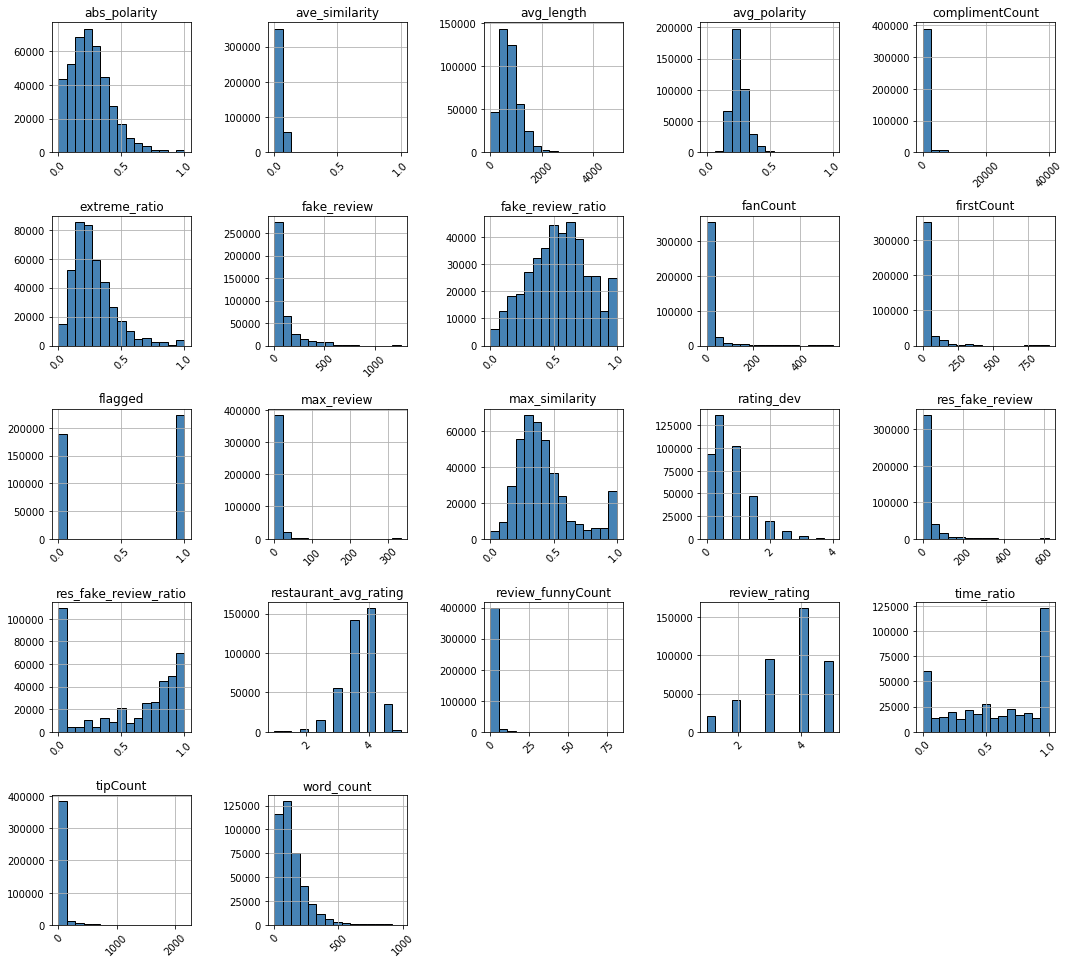

In [22]:
fig = df_filtered.hist(bins=15,
                 color='steelblue',
                 edgecolor='black', linewidth=1.0,
                 xlabelsize=10, ylabelsize=10,
                 xrot=45, yrot=0,
                 figsize=(10,9),
                 grid=True)

plt.tight_layout(rect=(0, 0, 1.5, 1.5))   

In [15]:
# Global_vars
seed = 1234
num_folds = 3
n_jobs = -1
hypertuned_experiment = True
is_save_results = True
scoring = 'accuracy'

In [16]:
X = df_model.drop('flagged', 1)
y = df_model.flagged

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)
print("X_train", X_train.shape)
print("X_test", X_test.shape)

X_train (329104, 33)
X_test (82276, 33)


In [20]:
# below code was run separately for the 4 classifiers
# Create pipelines
pipelines = create_pipelines(seed)

# Run cv experiment without hyper_param_tuning
results_df1 = run_cv_and_test(X_train, y_train, X_test, y_test, pipelines, scoring, seed, num_folds,
                             dataset_name='yelpReview', n_jobs=n_jobs)

Created these pipelines:
_LR
StandardScaler_LR
MinMaxScaler_LR
QuantileTransformer-Normal_LR
PowerTransformer-Yeo-Johnson_LR
_LDA
StandardScaler_LDA
MinMaxScaler_LDA
QuantileTransformer-Normal_LDA
PowerTransformer-Yeo-Johnson_LDA
_CART
StandardScaler_CART
MinMaxScaler_CART
QuantileTransformer-Normal_CART
PowerTransformer-Yeo-Johnson_CART
_NB
StandardScaler_NB
MinMaxScaler_NB
QuantileTransformer-Normal_NB
PowerTransformer-Yeo-Johnson_NB
First name is :  LR
_LR: 0.899147 (0.000794)


C:\Users\BD\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\BD\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


StandardScaler_LR: 0.900074 (0.000793)


C:\Users\BD\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


MinMaxScaler_LR: 0.899740 (0.000780)


C:\Users\BD\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


QuantileTransformer-Normal_LR: 0.898743 (0.000507)


C:\Users\BD\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


PowerTransformer-Yeo-Johnson_LR: 0.902162 (0.000622)


C:\Users\BD\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


_LDA: 0.887908 (0.000845)


C:\Users\BD\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


StandardScaler_LDA: 0.887908 (0.000845)


C:\Users\BD\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


MinMaxScaler_LDA: 0.887908 (0.000845)


C:\Users\BD\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


QuantileTransformer-Normal_LDA: 0.857127 (0.001127)
PowerTransformer-Yeo-Johnson_LDA: 0.890083 (0.000810)


C:\Users\BD\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


_CART: 0.892906 (0.001061)
StandardScaler_CART: 0.892885 (0.001058)
MinMaxScaler_CART: 0.892885 (0.001050)
QuantileTransformer-Normal_CART: 0.892888 (0.000955)
PowerTransformer-Yeo-Johnson_CART: 0.892809 (0.001007)
_NB: 0.840780 (0.001724)
StandardScaler_NB: 0.840446 (0.001286)
MinMaxScaler_NB: 0.840446 (0.001286)
QuantileTransformer-Normal_NB: 0.821564 (0.001059)
PowerTransformer-Yeo-Johnson_NB: 0.838398 (0.001414)

##############################Results##############################
_LR: 0.899147 (0.000794) [test_score:0.884]
StandardScaler_LR: 0.900074 (0.000793) [test_score:0.898]
MinMaxScaler_LR: 0.899740 (0.000780) [test_score:0.898]
QuantileTransformer-Normal_LR: 0.898743 (0.000507) [test_score:0.899]
PowerTransformer-Yeo-Johnson_LR: 0.902162 (0.000622) [test_score:0.901]

_LDA: 0.887908 (0.000845) [test_score:0.887]
StandardScaler_LDA: 0.887908 (0.000845) [test_score:0.887]
MinMaxScaler_LDA: 0.887908 (0.000845) [test_score:0.887]
QuantileTransformer-Normal_LDA: 0.857127 (0.00112

In [18]:
# Create pipelines
pipelines = create_pipelines(seed)

# Run cv experiment without hyper_param_tuning
results_df2 = run_cv_and_test(X_train, y_train, X_test, y_test, pipelines, scoring, seed, num_folds,
                             dataset_name='yelpReview', n_jobs=n_jobs)

Created these pipelines:
_XGB
StandardScaler_XGB
MinMaxScaler_XGB
MaxAbsScaler_XGB
QuantileTransformer-Normal_XGB
PowerTransformer-Yeo-Johnson_XGB
Normalizer_XGB
_AdA
StandardScaler_AdA
MinMaxScaler_AdA
MaxAbsScaler_AdA
QuantileTransformer-Normal_AdA
PowerTransformer-Yeo-Johnson_AdA
Normalizer_AdA
First name is :  XGB
_XGB: 0.929211 (0.001177)
StandardScaler_XGB: 0.929296 (0.001058)
MinMaxScaler_XGB: 0.929211 (0.001177)
MaxAbsScaler_XGB: 0.929211 (0.001177)
QuantileTransformer-Normal_XGB: 0.929527 (0.000557)
PowerTransformer-Yeo-Johnson_XGB: 0.929296 (0.001058)
Normalizer_XGB: 0.919807 (0.000677)
_AdA: 0.918621 (0.000698)
StandardScaler_AdA: 0.918621 (0.000698)
MinMaxScaler_AdA: 0.918621 (0.000698)
MaxAbsScaler_AdA: 0.918621 (0.000698)
QuantileTransformer-Normal_AdA: 0.918621 (0.000698)
PowerTransformer-Yeo-Johnson_AdA: 0.918621 (0.000698)
Normalizer_AdA: 0.885358 (0.000724)

##############################Results##############################
_XGB: 0.929211 (0.001177) [test_score:0.929

In [23]:
results_df2.head()

,Dataset,Classifier_Name,CV_mean,CV_std,Test_score
0,yelpReview,_XGB,0.929211,0.00117705,0.928874
1,yelpReview,StandardScaler_XGB,0.929296,0.0010577,0.928861
2,yelpReview,MinMaxScaler_XGB,0.929211,0.00117705,0.928861
3,yelpReview,MaxAbsScaler_XGB,0.929211,0.00117705,0.928874
4,yelpReview,QuantileTransformer-Normal_XGB,0.929527,0.00055722,0.929104


# Final Model

In [30]:
XGB_pipelines = Pipeline([
    ('QuantileTransformer-Normal', QuantileTransformer(output_distribution='normal')),
    ('XGB', xgb.XGBClassifier(random_state=seed))
])
XGB_pipelines.fit(X_train, y_train)

In [31]:
predicted = XGB_pipelines.predict(X_test)
print(metrics.classification_report(y_test, predicted))
print('Oveall F1-score: ', f1_score(y_test, predicted))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92     37560
           1       0.93      0.94      0.93     44716

    accuracy                           0.93     82276
   macro avg       0.93      0.93      0.93     82276
weighted avg       0.93      0.93      0.93     82276

Oveall F1-score:  0.9346221714184249
